* https://x.com/joker_peaches/status/1813786856326303936
* https://x.com/makaishi2/status/1814595311161254308

<img src="IMG_5031.jpg" width=40%>

In [1]:
using Distributions
using Optim
using QuadGK
using Roots
using StatsPlots
default(fmt=:png, legendfontsize=10)

"X ~ beta1, Y ~ beta2 のときの X - Y の分布のpdfを作成"
function get_pdf_of_diff(beta1::Beta, beta2::Beta)
    pdf_diff(Δ) = -1 ≤ Δ ≤ 1 ? quadgk(max(0, -Δ), min(1, 1-Δ)) do q
        pdf(beta1, q+Δ) * pdf(beta2, q)
    end[1] : 0.0
    pdf_diff
end

"X ~ beta1, Y ~ beta2 のときの X - Y の分布のcdfを作成"
function get_cdf_of_diff(beta1::Beta, beta2::Beta)
    cdf_diff(Δ) = Δ < -1 ? 0.0 : Δ ≤ 1 ? quadgk(max(0, -Δ), 1) do q
        cdf(beta1, q+Δ) * pdf(beta2, q)
    end[1] : 1.0
    cdf_diff
end

"累積分布函数 cdffunc(x) の逆函数を作成"
function get_quantile(cdffunc, xmin, xmax)
    quantilefunc(p) = p == 0 ? xmin : p == 1 ? xmax : find_zero((xmin, xmax)) do x
        cdffunc(x) - p
    end 
    quantilefunc
end

function expectation_value(f, pdffunc, xmin, xmax)
    quadgk(x -> f(x)*pdffunc(x), xmin, xmax)[1]
end

function highest_density_interval(quantilefunc, α = 0.05; alg = Brent())
    f(p) = quantilefunc(p + (1 - α)) - quantilefunc(p)
    o = optimize(f, 0, α, alg)
    p = o.minimizer
    quantilefunc.((p, p + (1 - α)))
end

function pvalue_hdi(pdffunc, cdffunc, xmin, xmax, x₀; alg=Brent())
    p₀ = pdffunc(x₀)
    xmode = optimize(δ -> -pdffunc(δ), xmin, xmax, alg).minimizer
    f(x) = pdffunc(x) - p₀
    if x₀ == xmode
        1.0
    elseif x₀ > xmode
        x₁ = find_zero(f, (xmin, xmode))
        cdffunc(x₁) + (1 - cdffunc(x₀))
    else
        x₁ = find_zero(f, (xmode, xmax))
        cdffunc(x₀) + (1 - cdffunc(x₁))
    end
end

function posterior_dist(k, n, prior::Beta=Beta(1, 1))
    a, b = params(prior)
    Beta(a+k, b+n-k)
end

function plot_result(;
        prior_X = Beta(1, 1), 
        prior_Y = Beta(1, 1), 
        x = 4, m = 5,
        y = 60, n = 100,
        α = 0.06,
    )

    @show prior_X
    @show prior_Y
    
    P = plot(p_X -> pdf(prior_X, p_X), -0.02, 1.02; label="prior of p_X")
    plot!(p_Y -> pdf(prior_Y, p_Y); label="prior of p_Y", ls=:dash)
    plot!(xguide="p_X or p_Y", yguide="probability density")
    plot!(legend=:outertop)
    plot!(xtick=0:0.1:1)

    @show (x, m)
    @show (y, n)
    @show posterior_X = posterior_dist(x, m, prior_X)
    @show posterior_Y = posterior_dist(y, n, prior_Y)
    @show mean(posterior_X)
    @show mean(posterior_Y)
    @show median(posterior_X)
    @show median(posterior_Y)
    
    Q = plot(δ -> pdf(posterior_X, δ), -0.02, 1.02; label="posterior of p_X")
    plot!(δ -> pdf(posterior_Y, δ); label="posterior of p_Y", ls=:dash)
    plot!(xguide="p_X or p_Y", yguide="probability density")
    plot!(legend=:outertop)
    plot!(xtick=0:0.1:1)

    pdf_Δp = get_pdf_of_diff(posterior_X, posterior_Y)
    cdf_Δp = get_cdf_of_diff(posterior_X, posterior_Y)
    quantile_Δp = get_quantile(cdf_Δp, -1.0, 1.0)

    @show cdf_Δp(0.0), 1-cdf_Δp(0.0)
    @show expectation_value(identity, pdf_Δp, -1.0, 1.0)
    @show α
    @show ci = highest_density_interval(quantile_Δp, α)
    #@show cdf_Δp(ci[2]) - cdf_Δp(ci[1])
    @show pval = pvalue_hdi(pdf_Δp, cdf_Δp, -1.0, 1.0, 0.0)
    #@show ci_pval = highest_density_interval(quantile_Δp, pval)
    ci_rounded = collect(round.(ci; sigdigits=4))
    
    R = plot(pdf_Δp, -0.75, 0.75; label="posterior of p_X - p_Y", c=:blue)
    plot!(collect(ci), fill(pdf_Δp(ci[1]), 2); label="$(100(1-α))% CI (HDI) $(ci_rounded)", lw=3, c=:red)
    vline!([0.0]; label="", c=:gray, ls=:dot)
    plot!(xtick=-1:0.25:1)
    plot!(xguide="p_X - p_Y", yguide="probability density")
    plot!(legend=:outertop)
    
    plot(P, Q, R; size=(500, 900), layout=(3, 1))
    plot!(leftmargin=4Plots.mm)
end

plot_result (generic function with 1 method)

prior_X = Beta{Float64}(α=1.0, β=1.0)
prior_Y = Beta{Float64}(α=1.0, β=1.0)
(x, m) = (4, 5)
(y, n) = (60, 100)
posterior_X = posterior_dist(x, m, prior_X) = Beta{Float64}(α=5.0, β=2.0)
posterior_Y = posterior_dist(y, n, prior_Y) = Beta{Float64}(α=61.0, β=41.0)
mean(posterior_X) = 0.7142857142857143
mean(posterior_Y) = 0.5980392156862745
median(posterior_X) = 0.7355500167043401
median(posterior_Y) = 0.5986824388758893
(cdf_Δp(0.0), 1 - cdf_Δp(0.0)) = (0.2376623137283716, 0.7623376862716285)
expectation_value(identity, pdf_Δp, -1.0, 1.0) = 0.1162464985994375
α = 0.06
ci = highest_density_interval(quantile_Δp, α) = (-0.1998896700024479, 0.3998402879948816)
pval = pvalue_hdi(pdf_Δp, cdf_Δp, -1.0, 1.0, 0.0) = 0.32931285779247715


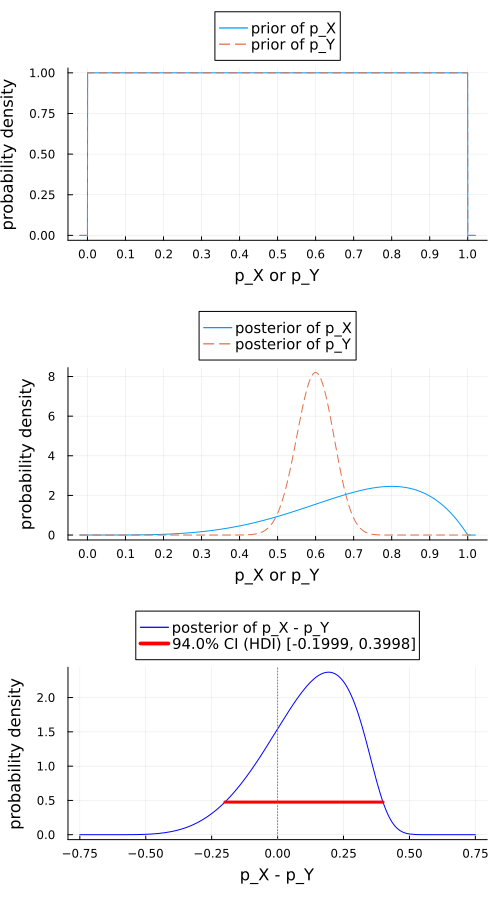

In [2]:
plot_result()

prior_X = Beta{Float64}(α=3.0, β=5.0)
prior_Y = Beta{Float64}(α=3.0, β=5.0)
(x, m) = (4, 5)
(y, n) = (60, 100)
posterior_X = posterior_dist(x, m, prior_X) = Beta{Float64}(α=7.0, β=6.0)
posterior_Y = posterior_dist(y, n, prior_Y) = Beta{Float64}(α=63.0, β=45.0)
mean(posterior_X) = 0.5384615384615384
mean(posterior_Y) = 0.5833333333333334
median(posterior_X) = 0.5404928142195595
median(posterior_Y) = 0.5838496033427365
(cdf_Δp(0.0), 1 - cdf_Δp(0.0)) = (0.615359629389039, 0.384640370610961)
expectation_value(identity, pdf_Δp, -1.0, 1.0) = -0.044871794871794254
α = 0.06
ci = highest_density_interval(quantile_Δp, α) = (-0.3088969489145304, 0.21701512040281573)
pval = pvalue_hdi(pdf_Δp, cdf_Δp, -1.0, 1.0, 0.0) = 0.7919418165982968


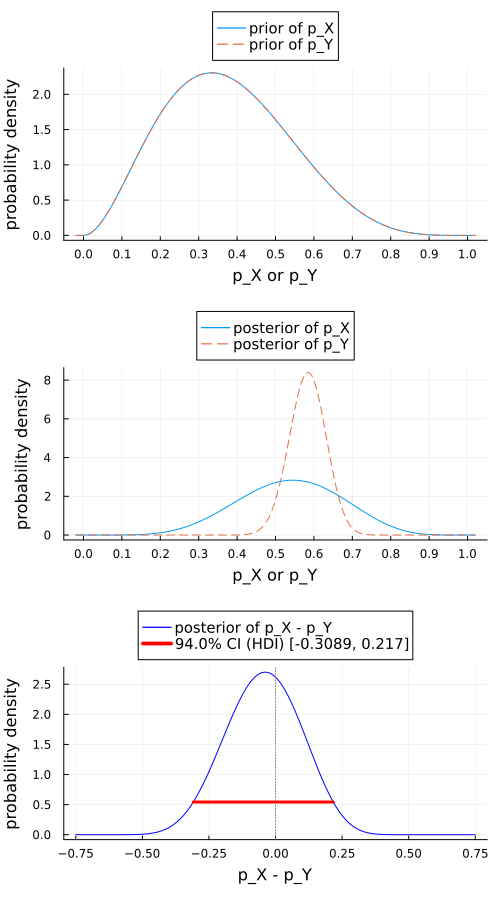

In [3]:
plot_result(; prior_X=Beta(3, 5), prior_Y=Beta(3, 5))

null_pval_bayes = 0.32931285779247715
null_pval_score = 0.37100223163381274
α = 0.06
ci_score = [-0.2217237132473934, 0.3985429269354874]
ci_bayes = [-0.1998896700024479, 0.3998402879948816]


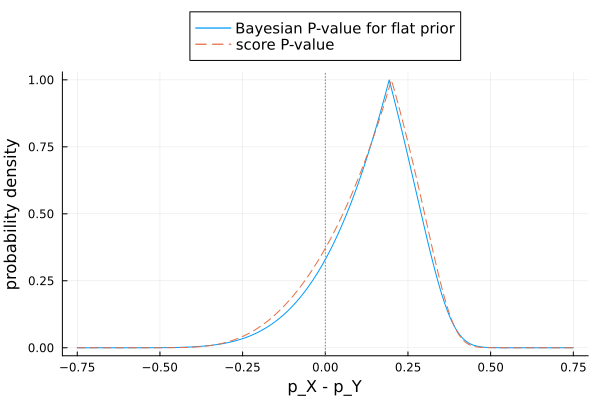

In [4]:
using Distributions
using Roots
using StatsPlots
default(fmt=:png)

myecdf(A, x) = count(≤(x), A)/length(A)
safemul(x, y) = x == 0 ? zero(x*y) : y == 0 ? zero(x*y) : x*y
safediv(x, y) = x == 0 ? zero(x/y) : isinf(y) ? zero(x/y) : x/y

### score method for risk difference

riskdiffhat_score(a, b, c, d) = safediv(a, a+b) - safediv(c, c+d)

function loglik_rd(a, b, c, d, q, Δ=0.0)
    p = q + Δ
    safemul(a, log(p)) + safemul(b, log(1-p)) + safemul(c, log(q)) + safemul(d, log(1-q))
end

function scorestat_q_rd(a, b, c, d, q, Δ=0.0)
    p = q + Δ
    safediv(a, p) - safediv(b, 1-p) + safediv(c, q) - safediv(d, 1-q)
end

function d_scorestat_q_rd(a, b, c, d, q, Δ=0.0)
    p = q + Δ
    -safediv(a, p^2) - safediv(b, (1-p)^2) - safediv(c, q^2) - safediv(d, (1-q)^2)
end

function scorestat_Δ_rd(a, b, c, d, q, Δ=0.0)
    p = q + Δ
    safediv(a, p) - safediv(b, 1-p)
end

function estimate_q_given_Δ_rd(a, b, c, d, Δ=0.0; alg=Bisection())
    qmin, qmax = max(0.0, -Δ), min(1.0, 1.0-Δ)
    a+c==0 && return qmin
    b+d==0 && return qmax
    f(q) = scorestat_q_rd(a, b, c, d, q, Δ)
    S_qmin = f(qmin + eps())
    S_qmax = f(qmax - eps())
    S_qmin ≥ 0 && S_qmax ≥ 0 && return S_qmin < S_qmax ? qmin : qmax
    S_qmin ≤ 0 && S_qmax ≤ 0 && return S_qmin < S_qmax ? qmax : qmin
    find_zero(f, (qmin + eps(), qmax - eps()), alg)
end

function varinv_scorestat_q_rd(a, b, c, d, q, Δ=0.0)
    p = q + Δ
    safediv(p*(1-p), a+b) + safediv(q*(1-q), c+d)
end

function chisqstat_rd_score(a, b, c, d; Δ=0.0, alg=Bisection())
    Δ = clamp(Δ, -1 + eps(), 1 - eps())
    q̃ = estimate_q_given_Δ_rd(a, b, c, d, Δ; alg)
    S = scorestat_Δ_rd(a, b, c, d, q̃, Δ)
    Vinv = varinv_scorestat_q_rd(a, b, c, d, q̃, Δ)
    safemul(S^2, Vinv)
end

function pvalue_rd_score(a, b, c, d; Δ=0.0, alg=Bisection())
    χ² = chisqstat_rd_score(a, b, c, d; Δ, alg)
    ccdf(Chisq(1), χ²)
end

function confint_rd_score(a, b, c, d; α=0.05, alg=Bisection())
    χ²_α = cquantile(Chisq(1), α)
    RDhat = riskdiffhat_score(a, b, c, d)
    g(Δ) = chisqstat_rd_score(a, b, c, d; Δ, alg) - χ²_α
    L = if g(-1 + eps()) > 0
        find_zero(g, (-1 + eps(), RDhat), alg)
    else
        -1.0
    end
    U = if g(1 - eps()) > 0
        find_zero(g, (RDhat, 1 - eps()), alg)
    else
        1.0
    end
    [L, U]
end

a, b, c, d = 4, 5-4, 60, 100-60

prior_X = Beta(1, 1)
prior_Y = Beta(1, 1)
posterior_X = posterior_dist(a, a+b, prior_X)
posterior_Y = posterior_dist(c, c+d, prior_Y)
pdf_Δp = get_pdf_of_diff(posterior_X, posterior_Y)
cdf_Δp = get_cdf_of_diff(posterior_X, posterior_Y)
quantile_Δp = get_quantile(cdf_Δp, -1.0, 1.0)

null_pval_bayes = pvalue_hdi(pdf_Δp, cdf_Δp, -1.0, 1.0, 0.0)
null_pval_score = pvalue_rd_score(a, b, c, d; Δ=0.0)

@show null_pval_bayes
@show null_pval_score

α = 0.06
@show α
ci_bayes = collect(highest_density_interval(quantile_Δp, α))
ci_score = confint_rd_score(a, b, c, d; α)
@show ci_score
@show ci_bayes

plot(δ -> pvalue_hdi(pdf_Δp, cdf_Δp, -1.0, 1.0, δ), -0.75, 0.75; label="Bayesian P-value for flat prior")
plot!(δ -> pvalue_rd_score(a, b, c, d; Δ=δ); label="score P-value", ls=:dash)
vline!([0.0]; label="", c=:gray, ls=:dot)
plot!(xguide="p_X - p_Y", yguide="probability density")
plot!(xtick=-1:0.25:1)
plot!(legend=:outertop)

α = 0.06
prior = Beta(1, 1) = Beta{Float64}(α=1.0, β=1.0)
posterior_p_X = posterior_dist(4, 5, prior) = Beta{Float64}(α=5.0, β=2.0)
posterior_p_Y = posterior_dist(60, 100, prior) = Beta{Float64}(α=61.0, β=41.0)
(myecdf(Δ, 0), 1 - myecdf(Δ, 0)) = (0.237546, 0.762454)
mean(Δ) = 0.11630493171366005
ci = myhdi(Δ, α) = (-0.1981091233324091, 0.40067857043823285)
pval = mypvalue(Δ, 0) = 0.33


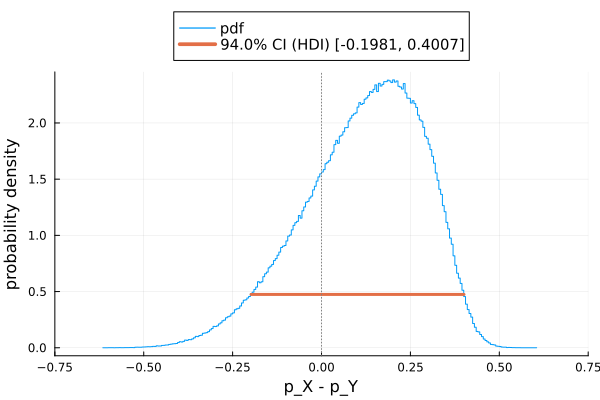

In [5]:
using Distributions
using StatsPlots
default(fmt=:png)

myecdf(A, x) = count(≤(x), A)/length(A)
myepdf(A, x; h=0.01) = (myecdf(A, x+h) - myecdf(A, x-h)) / (2h)

function _myhdi(A_sorted, α=0.05)
    n = length(A_sorted)
    m = floor(Int, (1 - α) * n)
    val, k = findmin(k -> A_sorted[k+m] - A_sorted[k], 1:n-m)
    A_sorted[k], A_sorted[k+m]
end

myhdi!(A, α=0.05) = _myhdi(sort!(A), α)
myhdi(A, α=0.05) = myhdi!(copy(A), α)

function _mypvalue(A_sorted, x=0.0; αs=0:0.0005:1) # very slow!
    k = findlast(αs) do α
        ci = _myhdi(A_sorted, α)
        ci[1] ≤ x ≤ ci[2]
    end
    round(αs[k], sigdigits=2)
end

mypvalue!(A, x) = _mypvalue(sort!(A), x)
mypvalue(A, x) = mypvalue!(copy(A), x)

function posterior_dist(k, n, prior::Beta=Beta(1, 1))
    a, b = params(prior)
    Beta(a+k, b+n-k)
end

α = 0.06
@show α

@show prior = Beta(1, 1)
@show posterior_p_X = posterior_dist(4, 5, prior)
@show posterior_p_Y = posterior_dist(60, 100, prior)

L = 10^6
p_X = rand(posterior_p_X, L)
p_Y = rand(posterior_p_Y, L)
Δ = p_X - p_Y

@show myecdf(Δ, 0), 1-myecdf(Δ, 0)
@show mean(Δ)
@show ci = myhdi(Δ, α)
#@show myecdf(Δ, ci[2]) - myecdf(Δ, ci[1])
@show pval = mypvalue(Δ, 0)
#@show ci_pval = myhdi(Δ, pval)

ci_rounded = collect(round.(ci; sigdigits=4))
stephist(Δ; norm=true, label="pdf", xlim=(-0.75, 0.75))
plot!(collect(ci), fill(myepdf(Δ, ci[1]), 2); label="$(100(1-α))% CI (HDI) $ci_rounded", lw=3)
vline!([0.0]; label="", c=:gray, ls=:dot)
plot!(xguide="p_X - p_Y", yguide="probability density")
plot!(xtick=-1:0.25:1)
plot!(legend=:outertop)